In [1]:
# libraries
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date

In [2]:
objects = ['AAPL',
           'CL=F']

In [3]:
df = web.DataReader(objects[1], data_source='yahoo', start='2012-01-01', end=date.today())

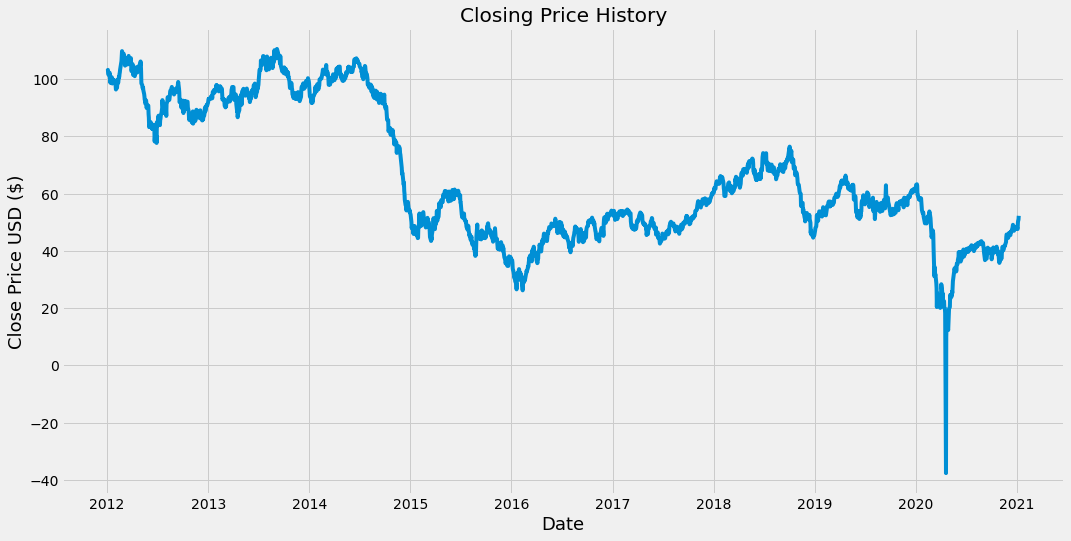

In [4]:
# visualization of closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_len = math.ceil(len(dataset) * 0.8)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
periods = [5,10,20,30]
period = 5

In [8]:
training_data = scaled_data[ : training_len , : ]
x_train = []
y_train = []
for i in range(period,len(training_data)):
  x_train.append(training_data[i-period : i , 0])
  y_train.append(training_data[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(1795, 5)
(1795, 5, 1)


In [9]:
testing_data = scaled_data[training_len - period : , : ]
x_test = []
y_test = dataset[training_len :, :]
for i in range(period,len(testing_data)):
  x_test.append(testing_data[i-period : i , 0])
x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)

(449, 5)
(449, 5, 1)


In [10]:
layers = [1,2,3,4]
neurons = [10,20,30,40,50,60]
neurons_num = 60
dropouts = [0.0,0.1,0.2,0.3,0.4,0.5]
dropout = dropouts[5]

In [11]:
# train.
model = Sequential()
model.add(LSTM(neurons_num, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,batch_size=1,epochs=15)

Epoch 1/15
1795/1795 [==============================] - 4s 1ms/step - loss: 0.0393
Epoch 2/15
1795/1795 [==============================] - 3s 1ms/step - loss: 0.0066
Epoch 3/15
1795/1795 [==============================] - 2s 1ms/step - loss: 0.0043
Epoch 4/15
1795/1795 [==============================] - 2s 1ms/step - loss: 0.0019
Epoch 5/15
1795/1795 [==============================] - 2s 1ms/step - loss: 0.0013
Epoch 6/15
1795/1795 [==============================] - 2s 1ms/step - loss: 9.2332e-04
Epoch 7/15
1795/1795 [==============================] - 2s 1ms/step - loss: 9.0409e-04
Epoch 8/15
1795/1795 [==============================] - 2s 1ms/step - loss: 8.9909e-04
Epoch 9/15
1795/1795 [==============================] - 3s 1ms/step - loss: 8.4994e-04
Epoch 10/15
1795/1795 [==============================] - 3s 1ms/step - loss: 8.9846e-04
Epoch 11/15
1795/1795 [==============================] - 3s 1ms/step - loss: 8.1450e-04
Epoch 12/15
1795/1795 [==============================] - 3s 1

In [14]:
# predict.
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[ : training_len]
valid = data[training_len : ]
valid['Predictions'] = predictions

In [18]:
print(predictions)

[[60.47881  ]
 [60.421795 ]
 [60.437763 ]
 [60.37743  ]
 [60.35848  ]
 [60.54892  ]
 [60.98768  ]
 [61.634403 ]
 [62.411186 ]
 [63.013313 ]
 [63.456543 ]
 [63.91202  ]
 [64.33114  ]
 [64.851616 ]
 [65.14902  ]
 [65.19125  ]
 [65.00115  ]
 [64.918945 ]
 [64.83745  ]
 [64.90853  ]
 [65.24239  ]
 [65.83397  ]
 [66.38301  ]
 [66.74588  ]
 [66.525154 ]
 [65.89521  ]
 [65.29337  ]
 [64.882576 ]
 [64.42907  ]
 [64.04758  ]
 [63.63597  ]
 [63.17068  ]
 [62.96114  ]
 [62.92889  ]
 [62.861855 ]
 [62.691547 ]
 [62.647984 ]
 [62.640354 ]
 [62.890087 ]
 [63.228413 ]
 [63.62955  ]
 [63.885174 ]
 [63.781284 ]
 [62.86512  ]
 [61.722553 ]
 [60.682842 ]
 [59.96538  ]
 [59.366947 ]
 [58.4274   ]
 [57.028698 ]
 [55.653034 ]
 [54.377316 ]
 [53.71013  ]
 [53.719925 ]
 [53.81324  ]
 [53.978725 ]
 [53.84226  ]
 [53.532345 ]
 [53.20298  ]
 [52.995876 ]
 [53.23866  ]
 [53.736286 ]
 [54.61659  ]
 [55.7766   ]
 [57.017914 ]
 [57.9402   ]
 [58.838615 ]
 [59.40872  ]
 [59.71536  ]
 [59.929237 ]
 [59.56608  ]
 [59.0

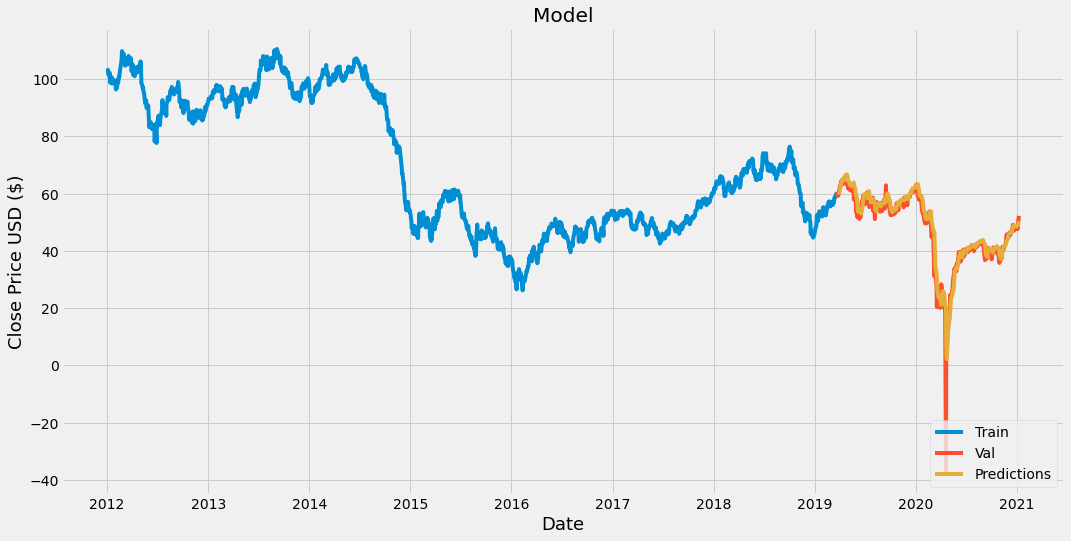

0.8124068590474288

In [15]:
# plot.
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse